In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import ipywidgets as widgets
import shapely

In [2]:
df = gpd.read_file("countries.json")

In [3]:
df

,featurecla,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,tlc,admin,...,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,filename,geometry
0,Admin-0 country,0,5,Costa Rica,CRI,0,2,Sovereign country,1,Costa Rica,...,None,None,None,None,None,None,None,None,CRI.geojson,"MULTIPOLYGON (((-83.6965 10.93659, -83.68687 1..."
1,Admin-0 country,0,5,Nicaragua,NIC,0,2,Sovereign country,1,Nicaragua,...,None,None,None,None,None,None,None,None,NIC.geojson,"MULTIPOLYGON (((-85.70174 11.08088, -85.70242 ..."
2,Admin-0 country,3,6,France,FR1,1,2,Dependency,1,Saint Martin,...,None,None,None,None,None,None,None,None,MAF.geojson,"POLYGON ((-63.01757 18.03339, -63.08589 18.058..."
3,Admin-0 country,3,6,Netherlands,NL1,1,2,Country,1,Sint Maarten,...,None,None,None,None,None,None,None,None,SXM.geojson,"POLYGON ((-63.107 18.06212, -63.08589 18.05851..."
4,Admin-0 country,0,5,Haiti,HTI,0,2,Sovereign country,1,Haiti,...,None,None,None,None,None,None,None,None,HTI.geojson,"MULTIPOLYGON (((-71.75744 19.71011, -71.74861 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,3,5,Mauritius,MUS,0,2,Sovereign country,1,Mauritius,...,None,None,None,None,None,None,None,None,MUS.geojson,"MULTIPOLYGON (((57.79575 -20.22275, 57.79396 -..."
254,Admin-0 country,5,5,United Kingdom,GB1,1,2,Disputed,1,British Indian Ocean Territory,...,None,None,None,None,None,None,None,None,IOT.geojson,"MULTIPOLYGON (((72.46754 -7.38388, 72.47153 -7..."
255,Admin-0 country,5,5,Maldives,MDV,0,2,Sovereign country,1,Maldives,...,None,None,None,None,None,None,None,None,MDV.geojson,"MULTIPOLYGON (((73.1631 -0.68182, 73.17254 -0...."
256,Admin-0 country,3,4,United Kingdom,GB1,1,2,Dependency,1,South Georgia and the Islands,...,None,None,None,None,None,None,None,None,SGS.geojson,"MULTIPOLYGON (((-27.25292 -59.45827, -27.24999..."


<Axes: >

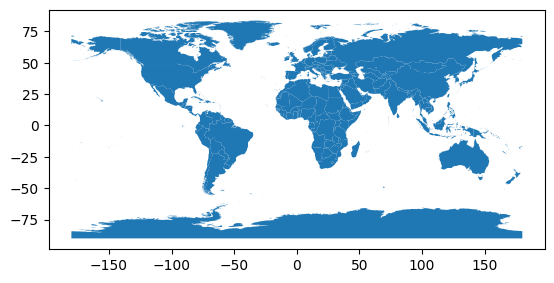

In [4]:
df.plot()

In [5]:
def plot_epicycle(selected, N):
    out.clear_output()
    with out:
        country = df[df['name'] == selected]
        geom = country.geometry.values[0]
        if geom.geom_type == 'MultiPolygon':
            largest = max(geom.geoms, key=lambda g: g.area)
        else:
            largest = geom
        largest: shapely.LinearRing = largest.exterior

        coords = np.array(list(largest.coords))
        x = coords[:, 0]
        y = coords[:, 1]

        gpd.GeoSeries([largest]).plot(label='Country Boundary')

        z = x + 1j * y
        n = len(z)
        z_fft = np.fft.fft(z) / n

        # Sort frequencies by amplitude (for best epicycle approximation)
        indices = np.argsort(-np.abs(z_fft))
        n_points = 500
        t = np.linspace(0, 1, n_points)
        approx = np.zeros(n_points, dtype=complex)

        # Use top N frequencies for the approximation
        for k in range(N):
            idx = indices[k]
            freq = idx if idx < n // 2 else idx - n
            amp = z_fft[idx]
            approx += amp * np.exp(2j * np.pi * freq * t)

        plt.plot(approx.real, approx.imag, 'r', label='Epicycle Approx')
        plt.legend()

        plt.show()

def on_country_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_epicycle(dropdown.value, n_slider.value)

def on_n_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_epicycle(dropdown.value, n_slider.value)

out = widgets.Output()

n_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='N:')

dropdown = widgets.Dropdown(
    options=sorted(df['name'].tolist()),
    description='Country:',
    disabled=False,
 )
dropdown.observe(on_country_change)
n_slider.observe(on_n_change)

ui = widgets.VBox([dropdown, n_slider])
display(ui, out)

# Initial plot
plot_epicycle(dropdown.value, n_slider.value)

Output()